In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time

import pyro
import torch
import pyro.optim as optim
from pyro.infer import SVI, JitTrace_ELBO, Predictive
from pyro.contrib.autoguide import AutoDiagonalNormal

from data_proc import load_raw_data, processData, transform_data, split_and_prep_data
from subreddit_model import subreddit_model, subreddit_guide
from model_utils import get_y_pred, get_type_only_y_pred, get_s_means, get_r_means, get_t_means, get_mean_y_pred, get_centered_phi, get_centered_rho
from inference import run_svi, plot_losses
from evaluation import plot_predictions, get_samples, gather_az_inference_data, plot_pp_pdf, plot_pp_cdf, plot_ppc, plot_residuals, MAE, MSE, R2, plot_predictions_by_subreddit


pyro.enable_validation(True)

# Complete Level Model
Here, we will model each post as coming from one of four types, one subreddit, and being about one story.

# Data

First, we load the Reddit datasets

In [2]:
comments, corrections, news = load_raw_data()

### Process and Unpack Data

In [3]:
COMMENTS_ONLY = True

In [4]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments, comments_only=COMMENTS_ONLY, minutes=60)

In [5]:
original_p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

p_data variables (in order):

0. bias
1. num_comments in first _ mins
2. num_subscribers at time of submission

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t_data variables (in order):

0. bias
1. Real News Dummy
2. Fake News Dummy
3. Correction on Real News Dummy
4. Correction on Fake News Dummy

s_data variables:

0. bias
1. country dummies (multiple may be "on")
2. author dummies

r_data variables:

0. bias
1. subreddit dummies

### Data Transformations

In [6]:
# before we change anything, save the original p_data
p_data = transform_data(original_p_data)

In [7]:
# Split into Test and Train datasets
train_data, test_data, unsplit_data = split_and_prep_data(original_p_data, p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits, train_frac=0.7)
original_p_data_train, p_data_train, y_train, p_types_train, p_stories_train, p_subreddits_train = train_data
original_p_data_test, p_data_test, y_test, p_types_test, p_stories_test, p_subreddits_test = test_data
t_data, s_data, r_data = unsplit_data

-----

# Modeling

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [8]:
model = subreddit_model
guide = subreddit_guide

# Inference

## SVI

In [9]:
svi, losses = run_svi(model, guide, train_data, unsplit_data, subsample=False, num_iters=2000, lr=1e-2, zero_inflated=True)

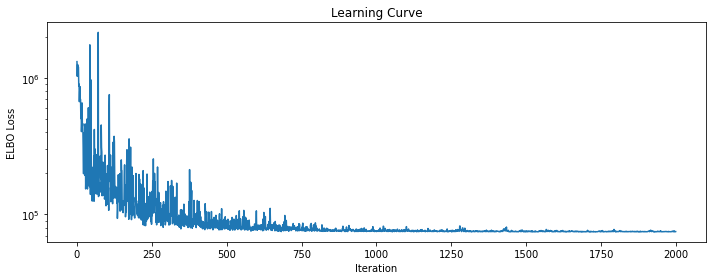

In [10]:
plot_losses(losses, log_scale = True, skip_first = 0)

----

# Evaluation

Recall:

Variables (in order):

0. num_comments
1. type
2. num_comments in first _ mins
3. num_subscribers at submission time

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

Check the fit

2 Regressions.

Post-Level Regression

y_pt = mu + phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

In [11]:
INDEP = 1

In [12]:
# get the means to be able to plot smoothly with just type data
# and for better interpretation
t_means = get_t_means(p_types_train, t_data)
r_means = get_r_means(p_subreddits_train, r_data)

In [13]:
y_pred = get_y_pred(p_data=p_data_train, t_data=t_data, r_data=r_data, p_types=p_types_train, p_subreddits=p_subreddits_train)


/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/model/evaluation.py:139: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


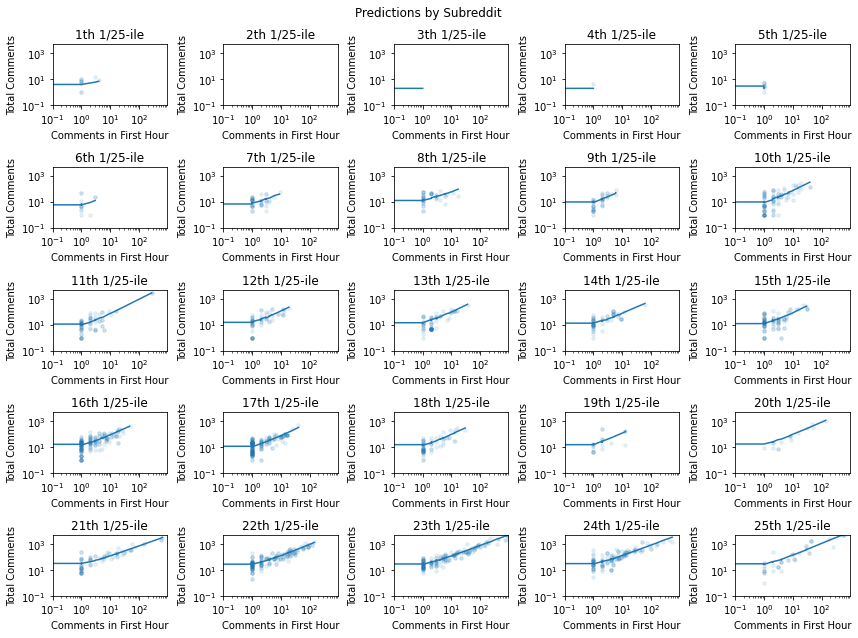

In [14]:
plot_predictions_by_subreddit(original_p_data_train, y_train, p_subreddits_train, original_p_data_train, y_pred, p_subreddits_train, indep=INDEP, log_scale=True, alpha=0.1)


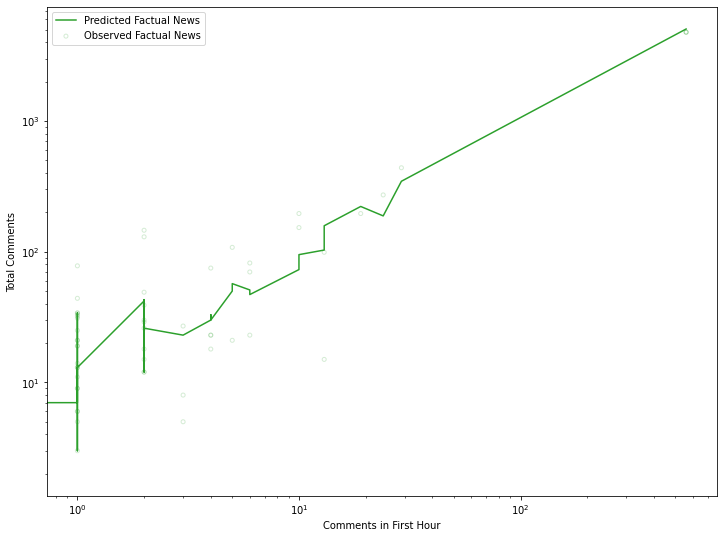

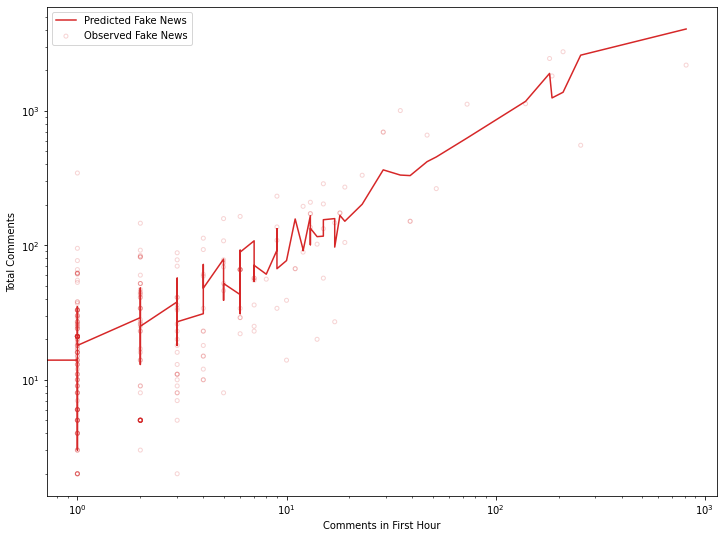

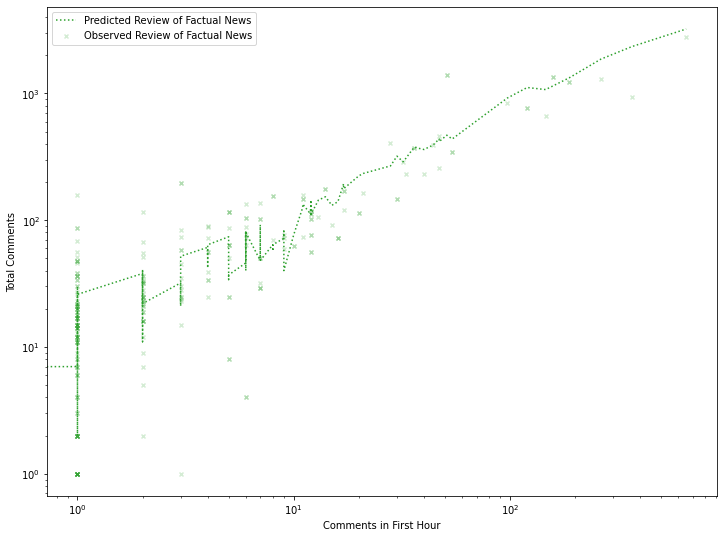

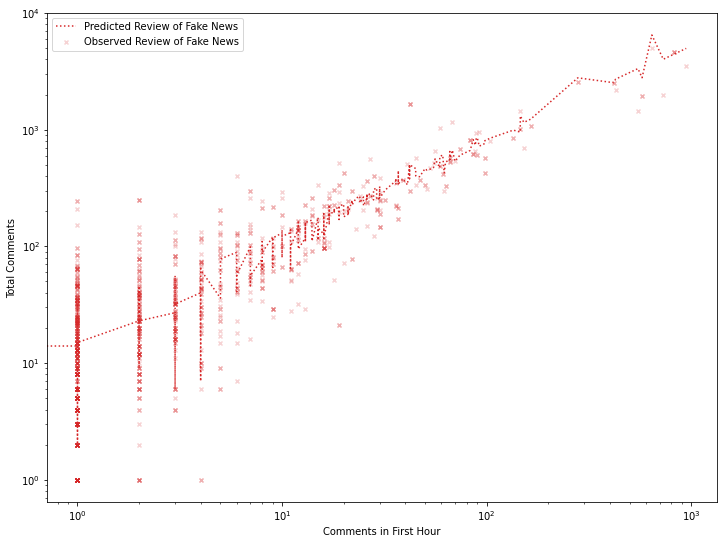

In [15]:
# Using all data (Jagged—other factors at play)


for i in range(4):
    plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred, p_types_train, indep=INDEP, only_type=i, log_scale=True, alpha=0.2)

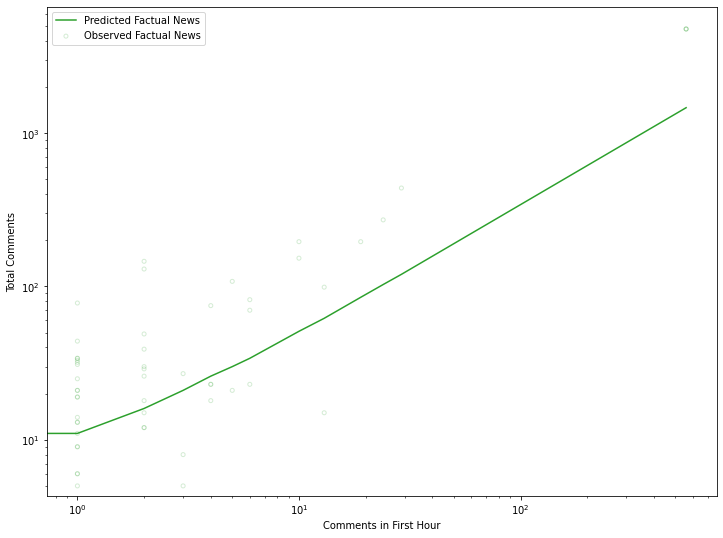

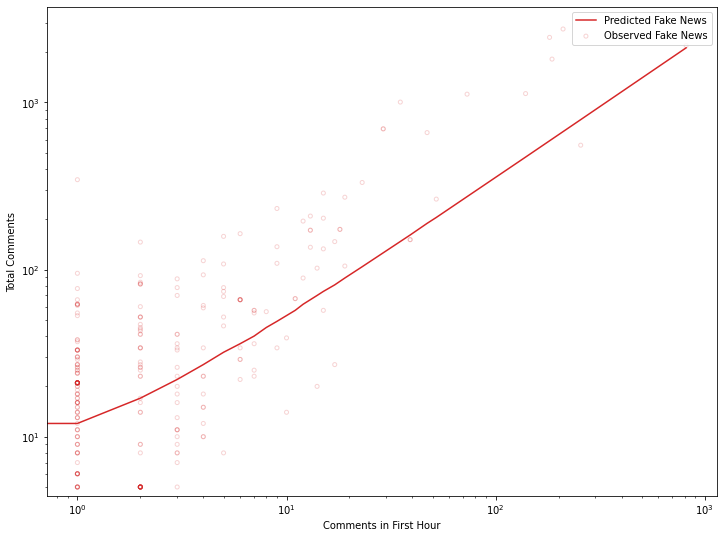

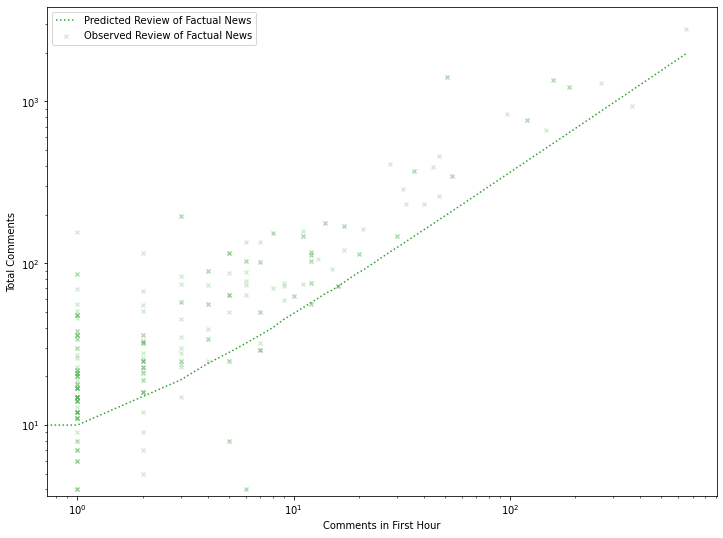

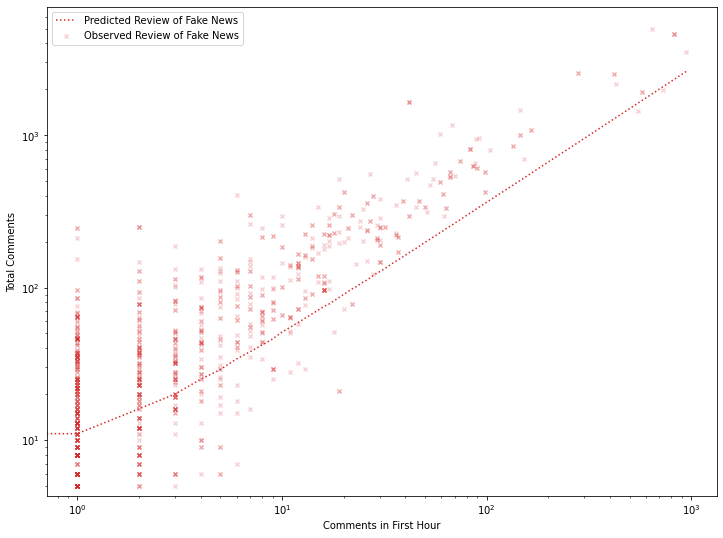

In [16]:
# Only using types (Smooth)
if COMMENTS_ONLY:
    y_pred_type_only = get_type_only_y_pred(p_data=p_data_train, t_data=t_data, p_types=p_types_train, r_means=r_means)
    for i in range(4):
        # actual predictions, using just type data
        plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred_type_only, p_types_train, indep=INDEP, only_type=i, log_scale=True, alpha=0.2)
        

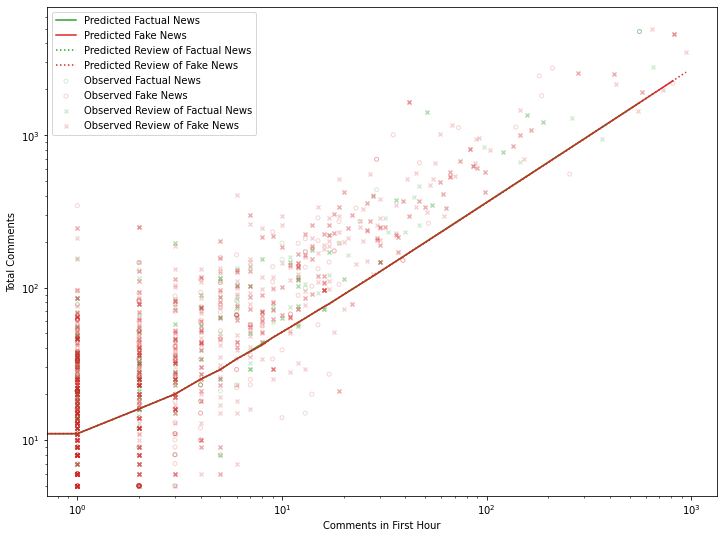

In [17]:
y_pred_mean = get_mean_y_pred(p_data=p_data_train, t_means=t_means, r_means=r_means)
plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred_mean, p_types_train, indep=INDEP, log_scale=True, alpha=0.2)

In [18]:
R2(y_train, y_pred_type_only)

0.6463158840202379

In [19]:
R2(y_train, y_pred_mean)

0.6545229480602943

In [20]:
R2(y_train, y_pred)

0.8679537070179422

In [21]:
R2(np.log(y_train+1), np.log(y_pred+1))

-0.2429482055250718

In [22]:
MAE(np.log(y_train+1), np.log(y_pred+1))

1.3428534800154162

In [23]:
MAE(y_train, y_pred)

10.718105776197062

### Interpretation

In [24]:
get_centered_phi(p_types_train, t_data)

tensor([[ 0.0641,  0.1163, -0.0965, -0.0066],
        [-0.0271, -0.0276,  0.0233,  0.0023]], dtype=torch.float64)

In [25]:
get_centered_rho(p_subreddits_train, r_data)

tensor([[-0.7225, -0.6448, -1.1129, -1.1413, -0.9466, -0.5538, -0.4326,  0.1930,
         -0.3189, -0.2799, -0.2527,  0.1342,  0.1061,  0.0673, -0.0109,  0.2392,
         -0.0034,  0.1417,  0.2156,  0.3656,  1.1229,  0.9029,  0.9996,  1.0662,
          0.8449],
        [-0.3353, -0.5793, -0.5624, -0.6048, -0.5613,  0.0572,  0.1458, -0.0066,
          0.3425,  0.2690,  0.2465,  0.2757,  0.2176,  0.1234,  0.2110,  0.1466,
          0.1890,  0.2154,  0.2692,  0.1110, -0.0978,  0.0103, -0.0523, -0.0546,
          0.0622]], dtype=torch.float64)

----

## Residuals

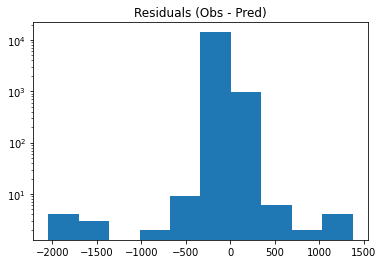

In [26]:
plot_residuals(np.array(y_train), np.array(y_pred))

----

Generate posterior predictive samples

In [27]:
svi_samples = get_samples(
    model, 
    guide, 
    p_data_train, 
    t_data, 
    s_data, 
    r_data, 
    None, 
    p_types_train, 
    p_stories_train,
    p_subreddits_train,
    True,
    num_samples=1000,
)

In [28]:
inf_data = gather_az_inference_data(svi_samples, y_train)

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/inference_data.py:790: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


---

Posterior distribution over latent variables:

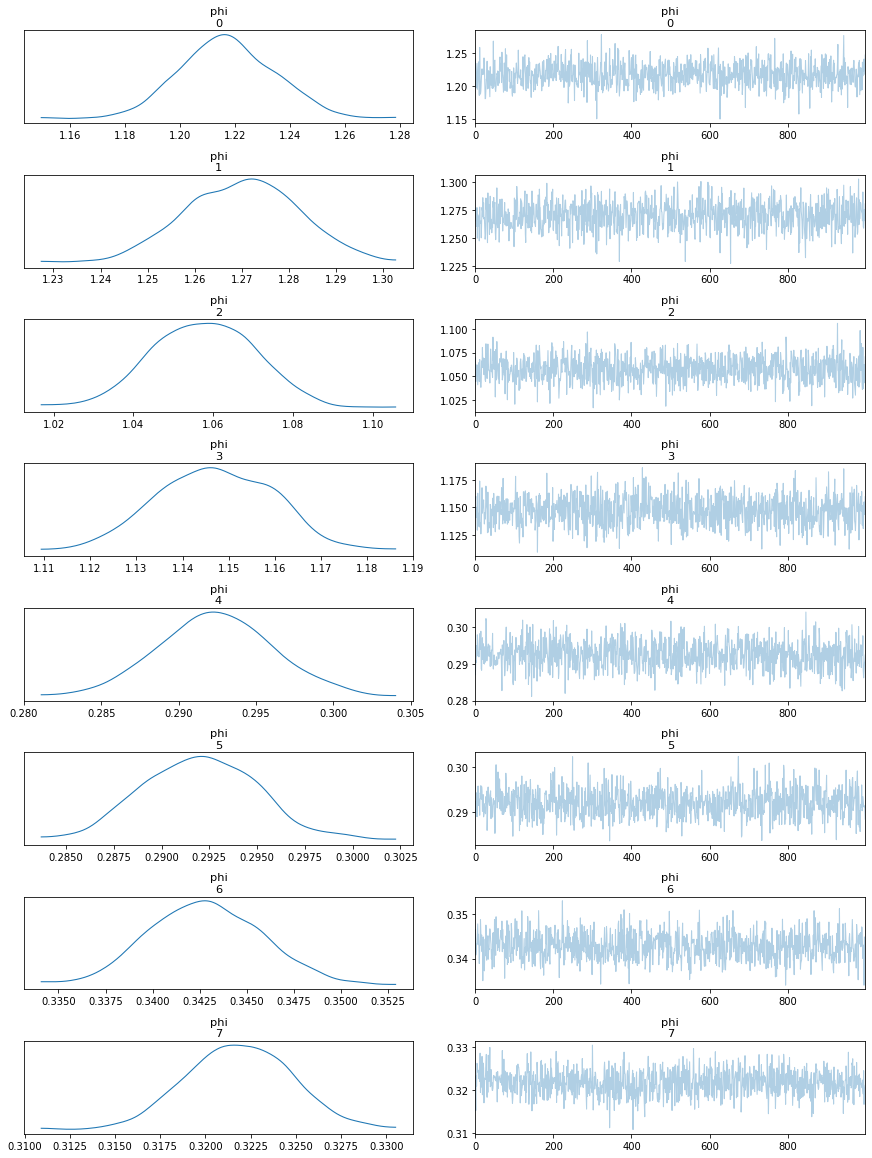

In [29]:
az.plot_trace(inf_data.posterior['phi'], compact=False)
plt.show()

---

Posterior predictive checks

In [ ]:
plot_pp_pdf(inf_data, y)

In [ ]:
plot_pp_cdf(inf_data, y)

- Max value

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: np.max(x, axis=0), "Max", log_stats = True)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: np.mean(x, axis=0), "Mean", log_stats = True)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: np.mean(np.log(x+1), axis=0), "Mean log", log_stats = False)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: np.var(x, axis=0), "Variance", log_stats = True)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: np.percentile(x, 90, axis=0), "90th %-ile (num obs)", log_stats = False)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: np.percentile(x, 99, axis=0), "99th %-ile (num obs)", log_stats = False)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: (x==0).mean(axis=0), "% = 0", log_stats = False)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: (x<10).mean(axis=0), "% < 10", log_stats = False)

In [ ]:
plot_ppc(svi_samples, y_train, lambda x: (x>1000).mean(axis=0), "% > 1000", log_stats = False)

# Why Pareto?
Our distribution of total comments follows a power law.

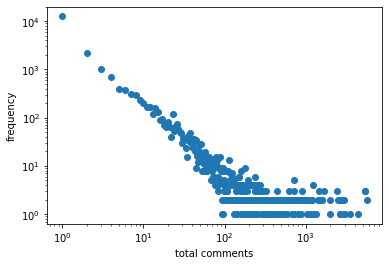

In [39]:
max_ct = np.max(y)
unique, counts = np.unique(y + 1, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")

plt.xlabel("total comments")
plt.ylabel("frequency")
plt.show()

Fake news: expect relatively flatter (more with lots, fewer with few!)

Reviews: expect steeper (fewer comments very common)

Note that our first hour comments are also distributed similarly.

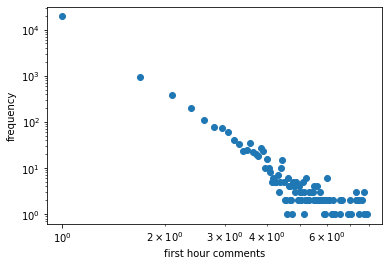

In [40]:
max_ct = np.max(p_data[:,1])
unique, counts = np.unique(p_data[:,1] + 1, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
#plt.xlim(1, 10000)
plt.xlabel("first hour comments")
plt.ylabel("frequency")
plt.show()

---